In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix, hstack

In [2]:
PATH = '../../data/'
### PATH on CMC AI
PATH = '/home/kai/data/kaggle/toxic/jc/data/'
train = pd.read_csv(PATH + 'cleaned_train.csv')
test = pd.read_csv(PATH + 'cleaned_test.csv')

train_sentence = train['comment_text_cleaned']
test_sentence = test['comment_text_cleaned']

text = pd.concat([train_sentence, test_sentence])

print(train.shape)
print(test.shape)

(159571, 30)
(153164, 24)


In [3]:
# CountVectorizer(input=’content’, encoding=’utf-8’, decode_error=’strict’, strip_accents=None,\
#                 lowercase=True, preprocessor=None, tokenizer=None, stop_words=None,\
#                 token_pattern=’(?u)\b\w\w+\b’, ngram_range=(1, 1), analyzer=’word’, max_df=1.0,\
#                 min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64’>)

# TfidfVectorizer(input=’content’, encoding=’utf-8’, decode_error=’strict’, strip_accents=None,\
#                 lowercase=True, preprocessor=None, tokenizer=None, analyzer=’word’, stop_words=None,\
#                 token_pattern=’(?u)\b\w\w+\b’, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None,\
#                 vocabulary=None, binary=False, dtype=<class ‘numpy.int64’>, norm=’l2’, use_idf=True,\
#                 smooth_idf=True, sublinear_tf=False)

print('getting tf count')
phrase_vectorizer = CountVectorizer(ngram_range=(1,3),
                                    strip_accents='unicode', 
                                    max_features=100000, 
                                    analyzer='word',
                                    token_pattern=r'\w{1,}')
char_vectorizer = CountVectorizer(ngram_range=(1,5), 
                                  strip_accents='unicode', 
                                  max_features=200000, 
                                  analyzer='char')

phrase_tfidf = TfidfTransformer(sublinear_tf=True)
char_tfidf = TfidfTransformer(sublinear_tf=True)


print('fitting char')
char_vectorizer.fit(text.values)
print('fitting phrase')
phrase_vectorizer.fit(text.values)
print('transforming train char')
train_char_count = char_vectorizer.transform(train_sentence.values)
print('transforming train phrase')
train_phrase_count = phrase_vectorizer.transform(train_sentence.values)
print('transforming test char')
test_char_count = char_vectorizer.transform(test_sentence.values)
print('transforming test phrase')
test_phrase_count = phrase_vectorizer.transform(test_sentence.values)




print('fitting char')
train_char = char_tfidf.fit_transform(train_char_count)
print('fitting phrase')
train_phrase = phrase_tfidf.fit_transform(train_phrase_count)
print('transforming test char')
test_char = char_tfidf.transform(test_char_count)
print('transforming test phrase')
test_phrase = phrase_tfidf.transform(test_phrase_count)




train_tfidf = hstack((train_char, train_phrase), format='csr')
test_tfidf = hstack((test_char, test_phrase), format='csr')



train_tf = hstack((train_char_count, train_phrase_count), format='csr')
test_tf = hstack((test_char_count, test_phrase_count), format='csr')

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_tf
train_tfidf

getting tf count
fitting char
fitting phrase
transforming train char
transforming train phrase
transforming test char
transforming test phrase
fitting char
fitting phrase
transforming test char
transforming test phrase


<159571x300000 sparse matrix of type '<class 'numpy.float64'>'
	with 153144273 stored elements in Compressed Sparse Row format>

In [6]:
def corr2_coeff(A,B):
    # this function returns corr matrix of n*a matrix A and n*b matrix B
    
    matrix_corr = np.zeros((A.shape[1], B.shape[1]))

    for j in range(A.shape[1]):
        a = A[:,j].todense()

        for i in range(B.shape[1]):
            b = B[:,i].todense()
            
            numerator = np.dot((a - a.mean()).T , (b - b.mean()))/a.shape[0]

            denomitor = np.std(a) * np.std(b)

            matrix_corr[j,i] = numerator / denomitor
        file = open('tfidf_printing.txt','a')
        file.write(str(j) +'\n')
        file.close()
    
        print(j)
    
    # Finally get corr coeff
    return matrix_corr

def get_corr_reg_model(label_cols, train_tf, train_tfidf, train, test_tf, test_tfidf):
    
    preds = np.zeros((test.shape[0], len(label_cols)))
    train_preds = np.zeros((train.shape[0], len(label_cols)))
    
    l = csr_matrix(train[label_cols].values)
    cor = pd.read_csv(PATH + 'corr.csv',header=None)
    cor = cor.fillna(0).values
    
    for i, j in enumerate(label_cols):
        print('fit', j)
        y = train[j].values
        r = cor[:,i]
        
        model = LogisticRegression()
        x_cor = train_tfidf.multiply(r).tocsr()
        model.fit(x_cor, y)
        preds[:, i] = model.predict_proba(test_tfidf.multiply(r))[:, 1]
        train_preds[:, i] = model.predict_proba(x_cor)[:, 1]
        print('accuracy is {}'.format(roc_auc_score(y, train_preds[:, i])))
        
    return preds, train_preds

def save(model_name, y_test, label_cols, path, is_train=False):
    if is_train:
        submission = pd.read_csv(path + 'sample_train.csv')
        file_name = 'train_' + model_name
    else:
        submission = pd.read_csv(path + 'sample_submission.csv')
        file_name = model_name
    submission[label_cols] = y_test
    submission.to_csv(path + '/' + file_name + '.csv', index=False)
    
print('done')

done


In [5]:
import os
os.environ['MKL_NUM_THREADS']='6'
os.environ['NUMEXPR_NUM_THREADS']='6'
os.environ['OMP_NUM_THREADS']='6'

print('predicting')
y_test, y_train = get_corr_reg_model(label_cols, train_tf, train_tfidf, train, test_tf, test_tfidf)
print('total score is {}'.format(roc_auc_score(train[label_cols], y_train)))



predicting
fit toxic
accuracy is 0.86868116314249
fit severe_toxic
accuracy is 0.9779500850333522
fit obscene
accuracy is 0.925687360104786
fit threat
accuracy is 0.9166701908283588
fit insult
accuracy is 0.9172383404220619
fit identity_hate
accuracy is 0.9110373586955783
total score is 0.9195440830377711
saving files


FileNotFoundError: [Errno 2] No such file or directory: '/home/kai/data/kaggle/toxic/jc/data/tfidf_cor_log_reg/tfidf_cor_log_reg.csv'

In [7]:
print('saving files')
model_name = 'tfidf_cor_log_reg'
save(model_name, y_test, label_cols, PATH)
save(model_name, y_train, label_cols, PATH, True)

print('done')

saving files
done


In [12]:
from sklearn.metrics import roc_curve
y_pred = y_train[:,0]

In [18]:
fp, tp ,thread = roc_curve(train['toxic'].values, y_pred)

In [19]:
import  matplotlib.pyplot  as plt

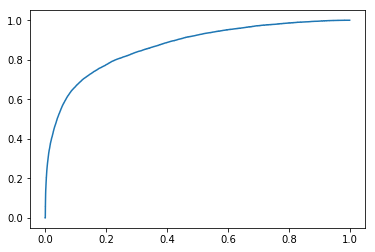

In [20]:
plt.plot(fp, tp)
plt.show()